In [2]:
from sympy import *
init_printing(use_latex='mathjax')

In [3]:
import re

## Set up tensors so that we may use reasonable math notation

In [4]:
from sympy import MutableDenseNDimArray as MArray

In [5]:
class MyMArray(MArray):
    
    def __mul__(self, other):
        try:
            return super().__mul__(other)
        except ValueError:
            if not isinstance(other, MyMArray):
                raise ValueError("Need MyMArray for contraction")
            
            rank_self = self.rank()
            prod = tensorproduct(self, other)
            contraction = tensorcontraction(prod, (rank_self - 1, rank_self))
            
            if type(contraction) == Array:
                return MyMArray(contraction)
            else:
                return contraction
    
    def __matmul__(self, other):
        try:
            return super().__mul__(other)
        except ValueError:
            if not isinstance(other, MyMArray):
                raise ValueError("Need MyMArray for tensor product")

            return MyMArray( tensorproduct(self, other) )
    
    def __pow__(self, other):
        try:
            return super().__mul__(other)
        except ValueError:
            if not isinstance(other, MyMArray):
                raise ValueError("Need MyMArray for double contraction")

            rank_self = self.rank()
            prod = tensorproduct(self, other)
            contract = tensorcontraction(prod, (rank_self - 1, rank_self))
            contraction = tensorcontraction(contract, (rank_self - 2, rank_self - 1))
            
            if type(contraction) == Array:
                return MyMArray(contraction)
            else:
                return contraction
        
    def ip(self, other):
        if not isinstance(other, MyMArray):
            raise ValueError("Need MyMArray for inner product")
        
        rank_self = self.rank()
        prod = tensorproduct(self, other)
        while rank_self > 0:
            prod = tensorcontraction(prod, (0, rank_self))
            rank_self -= 1
            
        return prod
    
def grad(M):
    return MyMArray(derive_by_array(M, xi))

def div(M):
    return tensorcontraction(grad(M), (0, 1))

def transpose_3(M):
    return permutedims(M, (1, 2, 0))

## Set up necessary objects that weak forms will be written in

In [83]:
vec_dim = 5
mat_dim = 3

x, y, z = symbols('x y z')
coords = (x, y)
# coords = (x, y, z) # uncomment for 3D
xi = MyMArray([x, y, z])

nx, ny, nz = symbols('n_x n_y n_z')
n = MyMArray([nx, ny, nz])

alpha, dt, L2, L3, Z = symbols(r'\alpha \delta\ t L_2 L_3 Z')

Q_vec = zeros(vec_dim, 1)
for i in range(vec_dim):
    Q_vec[i] = Function('Q_' + str(i + 1))(*coords)
    
Q0_vec = zeros(vec_dim, 1)
for i in range(vec_dim):
    Q0_vec[i] = Function('Q_{0' + str(i + 1) + '}')(*coords)

phi_vec = zeros(vec_dim, 1)
for i in range(vec_dim):
    phi_vec[i] = Function(r'\phi_' + str(i + 1))(*coords)
    
phi_i = Function(r'\phi_i')(*coords)
phi_j = Function(r'\phi_j')(*coords)
    
Lambda_vec = zeros(vec_dim, 1)
for i in range(vec_dim):
    Lambda_vec[i] = Function(r'\Lambda_' + str(i + 1))(*coords)
    
delta_Q_vec = zeros(vec_dim, 1)
for i in range(vec_dim):
    delta_Q_vec[i] = Function(r'\delta\ Q_' + str(i + 1))(*coords)
    
display([alpha, dt, L2, L3])
display(xi)
display(n)
display(Q_vec)
display(Q0_vec)
display(phi_vec)
display(Lambda_vec)
display(delta_Q_vec)

display(phi_i)
display(phi_j)

[\alpha, \delta t, L₂, L₃]

[x  y  z]

[nₓ  n_y  n_z]

⎡Q₁(x, y)⎤
⎢        ⎥
⎢Q₂(x, y)⎥
⎢        ⎥
⎢Q₃(x, y)⎥
⎢        ⎥
⎢Q₄(x, y)⎥
⎢        ⎥
⎣Q₅(x, y)⎦

⎡Q_{01}(x, y)⎤
⎢            ⎥
⎢Q_{02}(x, y)⎥
⎢            ⎥
⎢Q_{03}(x, y)⎥
⎢            ⎥
⎢Q_{04}(x, y)⎥
⎢            ⎥
⎣Q_{05}(x, y)⎦

⎡\phi₁(x, y)⎤
⎢           ⎥
⎢\phi₂(x, y)⎥
⎢           ⎥
⎢\phi₃(x, y)⎥
⎢           ⎥
⎢\phi₄(x, y)⎥
⎢           ⎥
⎣\phi₅(x, y)⎦

⎡\Lambda₁(x, y)⎤
⎢              ⎥
⎢\Lambda₂(x, y)⎥
⎢              ⎥
⎢\Lambda₃(x, y)⎥
⎢              ⎥
⎢\Lambda₄(x, y)⎥
⎢              ⎥
⎣\Lambda₅(x, y)⎦

⎡\delta\ Q₁(x, y)⎤
⎢                ⎥
⎢\delta\ Q₂(x, y)⎥
⎢                ⎥
⎢\delta\ Q₃(x, y)⎥
⎢                ⎥
⎢\delta\ Q₄(x, y)⎥
⎢                ⎥
⎣\delta\ Q₅(x, y)⎦

\phiᵢ(x, y)

\phi_j(x, y)

## Choose basis

In [7]:
basis = []
basis.append(MyMArray([[1, 0, 0],
                   [0, 0, 0],
                   [0, 0, -1]]))
basis.append(MyMArray([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 0]]))
basis.append(MyMArray([[0, 0, 1],
                   [0, 0, 0],
                   [1, 0, 0]]))
basis.append(MyMArray([[0, 0, 0],
                   [0, 1, 0],
                   [0, 0, -1]]))
basis.append(MyMArray([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0]]))

display(basis)

⎡⎡1  0  0 ⎤  ⎡0  1  0⎤  ⎡0  0  1⎤  ⎡0  0  0 ⎤  ⎡0  0  0⎤⎤
⎢⎢        ⎥  ⎢       ⎥  ⎢       ⎥  ⎢        ⎥  ⎢       ⎥⎥
⎢⎢0  0  0 ⎥, ⎢1  0  0⎥, ⎢0  0  0⎥, ⎢0  1  0 ⎥, ⎢0  0  1⎥⎥
⎢⎢        ⎥  ⎢       ⎥  ⎢       ⎥  ⎢        ⎥  ⎢       ⎥⎥
⎣⎣0  0  -1⎦  ⎣0  0  0⎦  ⎣1  0  0⎦  ⎣0  0  -1⎦  ⎣0  1  0⎦⎦

In [8]:
# Uncomment this for the standard orthonormal basis

# basis = []
# basis.append(MyMArray([[2/sqrt(3), 0, 0],
#                        [0, -1/sqrt(3), 0],
#                        [0, 0, -1/sqrt(3)]]))
# basis.append(MyMArray([[0, 0, 0],
#                    [0, 1, 0],
#                    [0, 0, -1]]))
# basis.append(MyMArray([[0, 1, 0],
#                    [1, 0, 0],
#                    [0, 0, 0]]))
# basis.append(MyMArray([[0, 0, 1],
#                    [0, 0, 0],
#                    [1, 0, 0]]))
# basis.append(MyMArray([[0, 0, 0],
#                    [0, 0, 1],
#                    [0, 1, 0]]))

# display(basis)

## Construct matrix objects from basis

In [84]:
Q = MyMArray.zeros(mat_dim, mat_dim)
for i in range(vec_dim):
    Q += basis[i]*Q_vec[i]
    
Q0 = MyMArray.zeros(mat_dim, mat_dim)
for i in range(vec_dim):
    Q0 += basis[i]*Q0_vec[i]
    
Lambda = MyMArray.zeros(mat_dim, mat_dim)
for i in range(vec_dim):
    Lambda += basis[i]*Lambda_vec[i]
    
delta_Q = MyMArray.zeros(mat_dim, mat_dim)
for i in range(vec_dim):
    delta_Q += basis[i]*delta_Q_vec[i]
    
Phi_i = []
for i in range(vec_dim):
    Phi_i.append( MyMArray(basis[i]*phi_i) )
    
Phi_j = []
for i in range(vec_dim):
    Phi_j.append( MyMArray(basis[i]*phi_j) )

display(Q)
display(Q0)
display(Lambda)
display(delta_Q_vec)
display(Phi_i)
display(Phi_j)

⎡Q₁(x, y)  Q₂(x, y)        Q₃(x, y)      ⎤
⎢                                        ⎥
⎢Q₂(x, y)  Q₄(x, y)        Q₅(x, y)      ⎥
⎢                                        ⎥
⎣Q₃(x, y)  Q₅(x, y)  -Q₁(x, y) - Q₄(x, y)⎦

⎡Q_{01}(x, y)  Q_{02}(x, y)          Q_{03}(x, y)        ⎤
⎢                                                        ⎥
⎢Q_{02}(x, y)  Q_{04}(x, y)          Q_{05}(x, y)        ⎥
⎢                                                        ⎥
⎣Q_{03}(x, y)  Q_{05}(x, y)  -Q_{01}(x, y) - Q_{04}(x, y)⎦

⎡\Lambda₁(x, y)  \Lambda₂(x, y)           \Lambda₃(x, y)         ⎤
⎢                                                                ⎥
⎢\Lambda₂(x, y)  \Lambda₄(x, y)           \Lambda₅(x, y)         ⎥
⎢                                                                ⎥
⎣\Lambda₃(x, y)  \Lambda₅(x, y)  -\Lambda₁(x, y) - \Lambda₄(x, y)⎦

⎡\delta\ Q₁(x, y)⎤
⎢                ⎥
⎢\delta\ Q₂(x, y)⎥
⎢                ⎥
⎢\delta\ Q₃(x, y)⎥
⎢                ⎥
⎢\delta\ Q₄(x, y)⎥
⎢                ⎥
⎣\delta\ Q₅(x, y)⎦

⎡⎡\phiᵢ(x, y)  0       0      ⎤  ⎡     0       \phiᵢ(x, y)  0⎤  ⎡     0       0  \phiᵢ(x, y)⎤  ⎡0       0            0      ⎤  ⎡0       0            0     ⎤⎤
⎢⎢                            ⎥  ⎢                           ⎥  ⎢                           ⎥  ⎢                            ⎥  ⎢                           ⎥⎥
⎢⎢     0       0       0      ⎥, ⎢\phiᵢ(x, y)       0       0⎥, ⎢     0       0       0     ⎥, ⎢0  \phiᵢ(x, y)       0      ⎥, ⎢0       0       \phiᵢ(x, y)⎥⎥
⎢⎢                            ⎥  ⎢                           ⎥  ⎢                           ⎥  ⎢                            ⎥  ⎢                           ⎥⎥
⎣⎣     0       0  -\phiᵢ(x, y)⎦  ⎣     0            0       0⎦  ⎣\phiᵢ(x, y)  0       0     ⎦  ⎣0       0       -\phiᵢ(x, y)⎦  ⎣0  \phiᵢ(x, y)       0     ⎦⎦

⎡⎡\phi_j(x, y)  0        0      ⎤  ⎡     0        \phi_j(x, y)  0⎤  ⎡     0        0  \phi_j(x, y)⎤  ⎡0       0              0      ⎤  ⎡0       0             0      ⎤⎤
⎢⎢                              ⎥  ⎢                             ⎥  ⎢                             ⎥  ⎢                              ⎥  ⎢                             ⎥⎥
⎢⎢     0        0        0      ⎥, ⎢\phi_j(x, y)       0        0⎥, ⎢     0        0       0      ⎥, ⎢0  \phi_j(x, y)        0      ⎥, ⎢0       0        \phi_j(x, y)⎥⎥
⎢⎢                              ⎥  ⎢                             ⎥  ⎢                             ⎥  ⎢                              ⎥  ⎢                             ⎥⎥
⎣⎣     0        0  -\phi_j(x, y)⎦  ⎣     0             0        0⎦  ⎣\phi_j(x, y)  0       0      ⎦  ⎣0       0        -\phi_j(x, y)⎦  ⎣0  \phi_j(x, y)       0      ⎦⎦

In [10]:
dLambda_mat = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dLambda_mat[i, j] = Function(r'\frac{\partial\ \Lambda_' + str(i + 1) + '}{\partial\ Q_' + str(j + 1) + "}")(x, y, z)
        
display(dLambda_mat)

⎡\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_1}{\partial\ Q_2}(x, y, z)  \frac{\partial\ \Lambda_1}{\partial\ Q_3}(x, y, z)  \frac{\partial
⎢                                                                                                                                                                          
⎢\frac{\partial\ \Lambda_2}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_2}{\partial\ Q_2}(x, y, z)  \frac{\partial\ \Lambda_2}{\partial\ Q_3}(x, y, z)  \frac{\partial
⎢                                                                                                                                                                          
⎢\frac{\partial\ \Lambda_3}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_3}{\partial\ Q_2}(x, y, z)  \frac{\partial\ \Lambda_3}{\partial\ Q_3}(x, y, z)  \frac{\partial
⎢                                                                                                                                           

In [11]:
dLambda = MyMArray.zeros(vec_dim, mat_dim, mat_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dLambda[j, :, :] += dLambda_mat[i, j] * basis[i]
            
display(dLambda)    

⎡⎡\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_2}{\partial\ Q_1}(x, y, z)                             \frac{\partial\ \Lambda_3}{\partial\ Q
⎢⎢                                                                                                                                                                         
⎢⎢\frac{\partial\ \Lambda_2}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_4}{\partial\ Q_1}(x, y, z)                             \frac{\partial\ \Lambda_5}{\partial\ Q
⎢⎢                                                                                                                                                                         
⎣⎣\frac{\partial\ \Lambda_3}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_5}{\partial\ Q_1}(x, y, z)  -\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z) - \frac{\part

_1}(x, y, z)                           ⎤  ⎡\frac{\partial\ \Lambda_1}{\partial\ Q_2}(x, y, z)  \frac{\partial\ \Lambda_2}{\partial\ Q_2}(x,

## Calculate each of the terms in the residual vector

In [12]:
R1 = zeros(vec_dim, 1)
for i in range(vec_dim):
    R1[i, 0] = Phi_i[i].ip(Q)

R1 = simplify(R1)
display(R1)

⎡(2⋅Q₁(x, y) + Q₄(x, y))⋅\phiᵢ(x, y)⎤
⎢                                   ⎥
⎢      2⋅Q₂(x, y)⋅\phiᵢ(x, y)       ⎥
⎢                                   ⎥
⎢      2⋅Q₃(x, y)⋅\phiᵢ(x, y)       ⎥
⎢                                   ⎥
⎢(Q₁(x, y) + 2⋅Q₄(x, y))⋅\phiᵢ(x, y)⎥
⎢                                   ⎥
⎣      2⋅Q₅(x, y)⋅\phiᵢ(x, y)       ⎦

In [13]:
R2 = zeros(vec_dim, 1)
for i in range(vec_dim):
    R2[i, 0] = -(1 + alpha * dt) * Phi_i[i].ip(Q0)

R2 = simplify(R2)
display(R2)

⎡(\alpha⋅\delta t + 1)⋅(-2⋅Q_{01}(x, y) - Q_{04}(x, y))⋅\phiᵢ(x, y)⎤
⎢                                                                  ⎥
⎢        -2⋅(\alpha⋅\delta t + 1)⋅Q_{02}(x, y)⋅\phiᵢ(x, y)         ⎥
⎢                                                                  ⎥
⎢        -2⋅(\alpha⋅\delta t + 1)⋅Q_{03}(x, y)⋅\phiᵢ(x, y)         ⎥
⎢                                                                  ⎥
⎢(\alpha⋅\delta t + 1)⋅(-Q_{01}(x, y) - 2⋅Q_{04}(x, y))⋅\phiᵢ(x, y)⎥
⎢                                                                  ⎥
⎣        -2⋅(\alpha⋅\delta t + 1)⋅Q_{05}(x, y)⋅\phiᵢ(x, y)         ⎦

In [14]:
R3 = zeros(vec_dim, 1)
for i in range(vec_dim):
    R3[i, 0] = -dt * (-Phi_i[i].ip(Lambda))

R3 = simplify(R3)
display(R3)

⎡\delta t⋅(2⋅\Lambda₁(x, y) + \Lambda₄(x, y))⋅\phiᵢ(x, y)⎤
⎢                                                        ⎥
⎢         2⋅\delta t⋅\Lambda₂(x, y)⋅\phiᵢ(x, y)          ⎥
⎢                                                        ⎥
⎢         2⋅\delta t⋅\Lambda₃(x, y)⋅\phiᵢ(x, y)          ⎥
⎢                                                        ⎥
⎢\delta t⋅(\Lambda₁(x, y) + 2⋅\Lambda₄(x, y))⋅\phiᵢ(x, y)⎥
⎢                                                        ⎥
⎣         2⋅\delta t⋅\Lambda₅(x, y)⋅\phiᵢ(x, y)          ⎦

In [15]:
E1 = zeros(vec_dim, 1)
for i in range(vec_dim):
    E1[i, 0] = -grad(Phi_i[i]).ip(grad(Q))
    
E1 = simplify(E1)
display(E1)

⎡    ∂            ∂                   ∂            ∂                 ∂            ∂                 ∂            ∂              ⎤
⎢- 2⋅──(Q₁(x, y))⋅──(\phiᵢ(x, y)) - 2⋅──(Q₁(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₄(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₄(x, y))⋅──(\phiᵢ(x, y))⎥
⎢    ∂x           ∂x                  ∂y           ∂y                ∂x           ∂x                ∂y           ∂y             ⎥
⎢                                                                                                                               ⎥
⎢                                   ∂            ∂                   ∂            ∂                                             ⎥
⎢                               - 2⋅──(Q₂(x, y))⋅──(\phiᵢ(x, y)) - 2⋅──(Q₂(x, y))⋅──(\phiᵢ(x, y))                               ⎥
⎢                                   ∂x           ∂x                  ∂y           ∂y                                            ⎥
⎢                                                                                         

In [16]:
E2 = zeros(vec_dim, 1)
for i in range(vec_dim):
    E2[i, 0] = -transpose_3( grad(Phi_i[i]) ).ip(grad(Q))
    
E2 = simplify(E2)
display(E2)

⎡                                 ∂            ∂                 ∂            ∂                                             ⎤
⎢                               - ──(Q₁(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₂(x, y))⋅──(\phiᵢ(x, y))                               ⎥
⎢                                 ∂x           ∂x                ∂x           ∂y                                            ⎥
⎢                                                                                                                           ⎥
⎢  ∂            ∂                 ∂            ∂                 ∂            ∂                 ∂            ∂              ⎥
⎢- ──(Q₁(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₂(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₂(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₄(x, y))⋅──(\phiᵢ(x, y))⎥
⎢  ∂y           ∂x                ∂x           ∂x                ∂y           ∂y                ∂x           ∂y             ⎥
⎢                                                                                                                     

In [17]:
E31 = zeros(vec_dim, 1)
for i in range(vec_dim):
    E31[i, 0] = -grad(Phi_i[i]).ip(Q * grad(Q))
    
E31 = simplify(E31)
display(E31)

⎡  ⎛⎛∂              ∂           ⎞            ⎛∂              ∂           ⎞         ⎞ ∂                 ⎛⎛∂              ∂           ⎞            ⎛∂              ∂         
⎢- ⎜⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅Q₁(x, y) + ⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅Q₂(x, y)⎟⋅──(\phiᵢ(x, y)) - ⎜⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅Q₂(x, y) + ⎜──(Q₁(x, y)) + ──(Q₄(x, y
⎢  ⎝⎝∂x             ∂x          ⎠            ⎝∂y             ∂y          ⎠         ⎠ ∂x                ⎝⎝∂x             ∂x          ⎠            ⎝∂y             ∂y        
⎢                                                                                                                                                                          
⎢                                                                                                      ⎛         ∂                       ∂           ⎞ ∂                   
⎢                                                                                                  - 2⋅⎜Q₁(x, y)⋅──(Q₂(x, y)) + Q₂(x, y)⋅──(

In [18]:
E32 = zeros(vec_dim, 1)
for i in range(vec_dim):
    E32[i, 0] = -Rational(1, 2) * Phi_i[i].ip(grad(Q) ** transpose_3( grad(Q) ))
    
E32 = simplify(E32)
display(E32)

⎡                                            ⎛                2                                             2                 2                 2                 2⎞       
⎢                                            ⎜  ⎛∂           ⎞    ∂            ∂              ⎛∂           ⎞    ⎛∂           ⎞    ⎛∂           ⎞    ⎛∂           ⎞ ⎟       
⎢                                            ⎜- ⎜──(Q₁(x, y))⎟  - ──(Q₁(x, y))⋅──(Q₄(x, y)) - ⎜──(Q₂(x, y))⎟  - ⎜──(Q₃(x, y))⎟  - ⎜──(Q₄(x, y))⎟  - ⎜──(Q₅(x, y))⎟ ⎟⋅\phiᵢ(
⎢                                            ⎝  ⎝∂x          ⎠    ∂x           ∂x             ⎝∂x          ⎠    ⎝∂x          ⎠    ⎝∂x          ⎠    ⎝∂x          ⎠ ⎠       
⎢                                                                                                                                                                          
⎢ ⎛⎛∂              ∂           ⎞ ⎛∂              ∂           ⎞   ∂            ∂                ∂            ∂                ∂            ∂ 

## Calculate each of the terms in the Jacobian matrix

In [19]:
dR1 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dR1[i, j] = Phi_i[i].ip(Phi_j[j])

dR1 = simplify(dR1)
display(dR1)

⎡2⋅\phiᵢ(x, y)⋅\phi_j(x, y)              0                           0                \phiᵢ(x, y)⋅\phi_j(x, y)               0             ⎤
⎢                                                                                                                                          ⎥
⎢            0               2⋅\phiᵢ(x, y)⋅\phi_j(x, y)              0                           0                           0             ⎥
⎢                                                                                                                                          ⎥
⎢            0                           0               2⋅\phiᵢ(x, y)⋅\phi_j(x, y)              0                           0             ⎥
⎢                                                                                                                                          ⎥
⎢ \phiᵢ(x, y)⋅\phi_j(x, y)               0                           0               2⋅\phiᵢ(x, y)⋅\phi_j(x, y)              0             ⎥
⎢            

In [20]:
dR2 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dR2[i, j] = dt * Phi_i[i].ip(dLambda[j, :, :] * phi_j)

dR2 = simplify(dR2)
display(dR2)

⎡\delta t⋅(2⋅\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z) + \frac{\partial\ \Lambda_4}{\partial\ Q_1}(x, y, z))⋅\phiᵢ(x, y)⋅\phi_j(x, y)  \delta t⋅(2⋅\frac{\partial\
⎢                                                                                                                                                                          
⎢                           2⋅\delta t⋅\frac{\partial\ \Lambda_2}{\partial\ Q_1}(x, y, z)⋅\phiᵢ(x, y)⋅\phi_j(x, y)                                                         
⎢                                                                                                                                                                          
⎢                           2⋅\delta t⋅\frac{\partial\ \Lambda_3}{\partial\ Q_1}(x, y, z)⋅\phiᵢ(x, y)⋅\phi_j(x, y)                                                         
⎢                                                                                                                                           

In [21]:
dE1 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dE1[i, j] = -grad(Phi_i[i]).ip(grad(Phi_j[j]))
display(dE1)

⎡    ∂               ∂                    ∂               ∂                                                                                                                
⎢- 2⋅──(\phiᵢ(x, y))⋅──(\phi_j(x, y)) - 2⋅──(\phiᵢ(x, y))⋅──(\phi_j(x, y))                                      0                                                          
⎢    ∂x              ∂x                   ∂y              ∂y                                                                                                               
⎢                                                                                                                                                                          
⎢                                                                               ∂               ∂                    ∂               ∂                                     
⎢                                    0                                      - 2⋅──(\phiᵢ(x, y))⋅──(\phi_j(x, y)) - 2⋅──(\phiᵢ(x, y))⋅──(\phi

In [22]:
dE2 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dE2[i, j] = -transpose_3( grad(Phi_i[i]) ).ip( grad(Phi_j[j]) )
        
dE2 = simplify(dE2)
display(dE2)

⎡ ∂               ∂                                    ∂               ∂                                                                                                   
⎢-──(\phiᵢ(x, y))⋅──(\phi_j(x, y))                    -──(\phiᵢ(x, y))⋅──(\phi_j(x, y))                                    0                                  0            
⎢ ∂x              ∂x                                   ∂y              ∂x                                                                                                  
⎢                                                                                                                                                                          
⎢ ∂               ∂                   ∂               ∂                  ∂               ∂                                                     ∂               ∂           
⎢-──(\phiᵢ(x, y))⋅──(\phi_j(x, y))  - ──(\phiᵢ(x, y))⋅──(\phi_j(x, y)) - ──(\phiᵢ(x, y))⋅──(\phi_j(x, y))                  0                

In [23]:
dE31 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dE31[i, j] = -grad(Phi_i[i]).ip(Phi_j[j]*grad(Q) + Q*grad(Phi_j[j]))
        
dE31 = simplify(dE31)
display(dE31)

⎡    ⎛         ∂                           ∂               ⎞ ∂                 ⎛⎛∂              ∂           ⎞                         ∂                           ∂        
⎢- 2⋅⎜Q₂(x, y)⋅──(\phi_j(x, y)) + Q₄(x, y)⋅──(\phi_j(x, y))⎟⋅──(\phiᵢ(x, y)) - ⎜⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅\phi_j(x, y) + Q₁(x, y)⋅──(\phi_j(x, y)) + Q₂(x, y)⋅──(\phi_j
⎢    ⎝         ∂x                          ∂y              ⎠ ∂y                ⎝⎝∂x             ∂x          ⎠                         ∂x                          ∂y       
⎢                                                                                                                                                                          
⎢                                                                                                                                              ∂            ∂              
⎢                                                                                                                              -2⋅\phi_j(x, 

In [24]:
dE32 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dE32[i, j] = -Phi_i[i].ip(grad(Phi_j[j]) ** transpose_3( grad(Q) ))
        
dE32 = simplify(dE32)
display(dE32)

⎡                          ⎛    ∂              ∂           ⎞             ∂                                                                            ∂            ∂       
⎢                          ⎜- 2⋅──(Q₁(x, y)) - ──(Q₄(x, y))⎟⋅\phiᵢ(x, y)⋅──(\phi_j(x, y))                                              -2⋅\phiᵢ(x, y)⋅──(Q₂(x, y))⋅──(\phi_
⎢                          ⎝    ∂x             ∂x          ⎠             ∂x                                                                           ∂x           ∂x      
⎢                                                                                                                                                                          
⎢⎛  ⎛  ∂              ∂           ⎞ ∂                  ⎛  ∂              ∂           ⎞ ∂               ⎞                ⎛  ∂            ∂                  ∂            ∂  
⎢⎜- ⎜2⋅──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅──(\phi_j(x, y)) - ⎜2⋅──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅──(\phi_j(x, y))⎟⋅\phiᵢ(x, y)  2⋅⎜- ──(Q₂(x, y))⋅──(\

## Calculate boundary value inner products

In [25]:
bE1 = zeros(vec_dim, 1)
for i in range(vec_dim):
    bE1[i, 0] = Phi_i[i].ip(n * grad(Q))
    
bE1 = simplify(bE1)
display(bE1)

⎡⎛     ∂                 ∂                    ∂                  ∂           ⎞            ⎤
⎢⎜2⋅nₓ⋅──(Q₁(x, y)) + nₓ⋅──(Q₄(x, y)) + 2⋅n_y⋅──(Q₁(x, y)) + n_y⋅──(Q₄(x, y))⎟⋅\phiᵢ(x, y)⎥
⎢⎝     ∂x                ∂x                   ∂y                 ∂y          ⎠            ⎥
⎢                                                                                         ⎥
⎢                     ⎛   ∂                  ∂           ⎞                                ⎥
⎢                   2⋅⎜nₓ⋅──(Q₂(x, y)) + n_y⋅──(Q₂(x, y))⎟⋅\phiᵢ(x, y)                    ⎥
⎢                     ⎝   ∂x                 ∂y          ⎠                                ⎥
⎢                                                                                         ⎥
⎢                     ⎛   ∂                  ∂           ⎞                                ⎥
⎢                   2⋅⎜nₓ⋅──(Q₃(x, y)) + n_y⋅──(Q₃(x, y))⎟⋅\phiᵢ(x, y)                    ⎥
⎢                     ⎝   ∂x                 ∂y          ⎠                      

In [26]:
bE2 = zeros(vec_dim, 1)
for i in range(vec_dim):
    bE2[i, 0] = Phi_i[i].ip(n * transpose_3( grad(Q) ))
    
bE2 = simplify(bE2)
display(bE2)

⎡                            ⎛   ∂                  ∂                  ∂           ⎞                                        ⎤
⎢                            ⎜nₓ⋅──(Q₁(x, y)) + n_y⋅──(Q₂(x, y)) + n_z⋅──(Q₃(x, y))⎟⋅\phiᵢ(x, y)                            ⎥
⎢                            ⎝   ∂x                 ∂x                 ∂x          ⎠                                        ⎥
⎢                                                                                                                           ⎥
⎢⎛   ∂                 ∂                  ∂                  ∂                  ∂                  ∂           ⎞            ⎥
⎢⎜nₓ⋅──(Q₁(x, y)) + nₓ⋅──(Q₂(x, y)) + n_y⋅──(Q₂(x, y)) + n_y⋅──(Q₄(x, y)) + n_z⋅──(Q₃(x, y)) + n_z⋅──(Q₅(x, y))⎟⋅\phiᵢ(x, y)⎥
⎢⎝   ∂y                ∂x                 ∂y                 ∂x                 ∂y                 ∂x          ⎠            ⎥
⎢                                                                                                                     

In [27]:
bE31 = zeros(vec_dim, 1)
for i in range(vec_dim):
    bE31[i, 0] = Phi_i[i].ip(n * (Q * grad(Q)))
    
bE31 = simplify(bE31)
display(bE31)

⎡⎛              ∂                          ∂                            ∂                          ∂                             ∂                           ∂             
⎢⎜2⋅nₓ⋅Q₁(x, y)⋅──(Q₁(x, y)) + nₓ⋅Q₁(x, y)⋅──(Q₄(x, y)) + 2⋅nₓ⋅Q₂(x, y)⋅──(Q₁(x, y)) + nₓ⋅Q₂(x, y)⋅──(Q₄(x, y)) + 2⋅n_y⋅Q₂(x, y)⋅──(Q₁(x, y)) + n_y⋅Q₂(x, y)⋅──(Q₄(x, y)) +
⎢⎝              ∂x                         ∂x                           ∂y                         ∂y                            ∂x                          ∂x            
⎢                                                                                                                                                                          
⎢                                                                                            ⎛   ⎛         ∂                       ∂           ⎞       ⎛         ∂         
⎢                                                                                          2⋅⎜nₓ⋅⎜Q₁(x, y)⋅──(Q₂(x, y)) + Q₂(x, y)⋅──(Q₂(x, 

## Automatically generate C++ code

In [28]:
from sympy.printing.cxx import CXX11CodePrinter

### Begin by making lists of objects relevant to dealii

In [85]:
Q_list = list(Q_vec)
Q0_list = list(Q0_vec)
delta_Q_list = list(delta_Q_vec)
phi_list = list([phi_i, phi_j])
Lambda_list = list(Lambda_vec)
normal_list = list(n)
symbol_list = [alpha, dt, L2, L3, Z]
symbol_list_code = ["alpha", "dt", "L2", "L3", "Z"]

display(Q_list)
display(Q0_list)
display(delta_Q_list)
display(phi_list)
display(Lambda_list)
display(normal_list)
display(symbol_list)

[Q₁(x, y), Q₂(x, y), Q₃(x, y), Q₄(x, y), Q₅(x, y)]

[Q_{01}(x, y), Q_{02}(x, y), Q_{03}(x, y), Q_{04}(x, y), Q_{05}(x, y)]

[\delta\ Q₁(x, y), \delta\ Q₂(x, y), \delta\ Q₃(x, y), \delta\ Q₄(x, y), \delta\ Q₅(x, y)]

[\phiᵢ(x, y), \phi_j(x, y)]

[\Lambda₁(x, y), \Lambda₂(x, y), \Lambda₃(x, y), \Lambda₄(x, y), \Lambda₅(x, y)]

[nₓ, n_y, n_z]

[\alpha, \delta t, L₂, L₃, Z]

In [30]:
dQ_vec = MyMArray.zeros(vec_dim, mat_dim)
ddQ_vec = MyMArray.zeros(vec_dim, mat_dim, mat_dim)
dphi_vec = zeros(len(coords), mat_dim)

for i in range(vec_dim):
    for j in range(mat_dim):
        dQ_vec[i, j] = Q_list[i].diff(xi[j])
        
for i in range(vec_dim):
    for j in range(mat_dim):
        for k in range(mat_dim):
            ddQ_vec[i, j, k] = Q_list[i].diff(xi[j]).diff(xi[k])
        
for i in range(len(coords)):
    for j in range(mat_dim):
        dphi_vec[i, j] = phi_list[i].diff(xi[j])
        
        
dQ_vec_list = dQ_vec.tolist()
ddQ_vec_list = ddQ_vec.tolist()
dphi_vec_list = dphi_vec.tolist()
dLambda_mat_list = dLambda_mat.tolist()


display(dQ_vec_list)
display(ddQ_vec_list)
display(dphi_vec_list)
display(dLambda_mat_list)

⎡⎡∂             ∂              ⎤  ⎡∂             ∂              ⎤  ⎡∂             ∂              ⎤  ⎡∂             ∂              ⎤  ⎡∂             ∂              ⎤⎤
⎢⎢──(Q₁(x, y)), ──(Q₁(x, y)), 0⎥, ⎢──(Q₂(x, y)), ──(Q₂(x, y)), 0⎥, ⎢──(Q₃(x, y)), ──(Q₃(x, y)), 0⎥, ⎢──(Q₄(x, y)), ──(Q₄(x, y)), 0⎥, ⎢──(Q₅(x, y)), ──(Q₅(x, y)), 0⎥⎥
⎣⎣∂x            ∂y             ⎦  ⎣∂x            ∂y             ⎦  ⎣∂x            ∂y             ⎦  ⎣∂x            ∂y             ⎦  ⎣∂x            ∂y             ⎦⎦

⎡⎡⎡  2               2              ⎤  ⎡   2               2             ⎤           ⎤  ⎡⎡  2               2              ⎤  ⎡   2               2             ⎤          
⎢⎢⎢ ∂               ∂               ⎥  ⎢  ∂               ∂              ⎥           ⎥  ⎢⎢ ∂               ∂               ⎥  ⎢  ∂               ∂              ⎥          
⎢⎢⎢───(Q₁(x, y)), ─────(Q₁(x, y)), 0⎥, ⎢─────(Q₁(x, y)), ───(Q₁(x, y)), 0⎥, [0, 0, 0]⎥, ⎢⎢───(Q₂(x, y)), ─────(Q₂(x, y)), 0⎥, ⎢─────(Q₂(x, y)), ───(Q₂(x, y)), 0⎥, [0, 0, 0
⎢⎢⎢  2            ∂y ∂x             ⎥  ⎢∂y ∂x              2             ⎥           ⎥  ⎢⎢  2            ∂y ∂x             ⎥  ⎢∂y ∂x              2             ⎥          
⎣⎣⎣∂x                               ⎦  ⎣                 ∂y              ⎦           ⎦  ⎣⎣∂x                               ⎦  ⎣                 ∂y              ⎦          

 ⎤  ⎡⎡  2               2              ⎤  ⎡   2               2             ⎤           ⎤  ⎡⎡  2               2              ⎤  ⎡   2     

⎡⎡∂                ∂                 ⎤  ⎡∂                 ∂                  ⎤⎤
⎢⎢──(\phiᵢ(x, y)), ──(\phiᵢ(x, y)), 0⎥, ⎢──(\phi_j(x, y)), ──(\phi_j(x, y)), 0⎥⎥
⎣⎣∂x               ∂y                ⎦  ⎣∂x                ∂y                 ⎦⎦

[[\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z), \frac{\partial\ \Lambda_1}{\partial\ Q_2}(x, y, z), \frac{\partial\ \Lambda_1}{\partial\ Q_3}(x, y, z), \frac{\partia
l\ \Lambda_1}{\partial\ Q_4}(x, y, z), \frac{\partial\ \Lambda_1}{\partial\ Q_5}(x, y, z)], [\frac{\partial\ \Lambda_2}{\partial\ Q_1}(x, y, z), \frac{\partial\ \Lambda_2}
{\partial\ Q_2}(x, y, z), \frac{\partial\ \Lambda_2}{\partial\ Q_3}(x, y, z), \frac{\partial\ \Lambda_2}{\partial\ Q_4}(x, y, z), \frac{\partial\ \Lambda_2}{\partial\ Q_5}
(x, y, z)], [\frac{\partial\ \Lambda_3}{\partial\ Q_1}(x, y, z), \frac{\partial\ \Lambda_3}{\partial\ Q_2}(x, y, z), \frac{\partial\ \Lambda_3}{\partial\ Q_3}(x, y, z), \f
rac{\partial\ \Lambda_3}{\partial\ Q_4}(x, y, z), \frac{\partial\ \Lambda_3}{\partial\ Q_5}(x, y, z)], [\frac{\partial\ \Lambda_4}{\partial\ Q_1}(x, y, z), \frac{\partial\
 \Lambda_4}{\partial\ Q_2}(x, y, z), \frac{\partial\ \Lambda_4}{\partial\ Q_3}(x, y, z), \frac{\partial\ \Lambda_4}{\partial\ Q_4}(x, y, z),

## Create `MyPrinter` class which extends C++ printer to do necessary substitutions

In [31]:
class MyPrinter(CXX11CodePrinter):
    """
    This printer prints expressions as C++ code, and appropriately formats
    symbols that are specific to the nematic Q-tensor finite element simulation
    """
    
    def _print_Function(self, function):
        
        if function in Q_list:
            idx = Q_list.index(function)
            return self._print('Q_vec[q][{}]'.format(idx))
        if function in Q0_list:
            idx = Q0_list.index(function)
            return self._print('Q0_vec[q][{}]'.format(idx))
        if function in phi_list:
            idx = phi_list.index(function)
            if idx == 0:
                return self._print('fe_values.shape_value(i, q)')
            elif idx == 1:
                return self._print('fe_values.shape_value(j, q)')
            else:
                raise ValueError("Index out of bounds for phi")
        if function in Lambda_list:
            idx = Lambda_list.index(function)
            return self._print('Lambda_vec[{}]'.format(idx))
        for i, sublist in enumerate(dLambda_mat_list):
            if function in sublist:
                j = sublist.index(function)
                return self._print('dLambda_dQ[{}][{}]'.format(i, j))
        
        return super()._print_Function(function)
        
    def _print_Derivative(self, derivative):
        
        for i, sublist in enumerate(dQ_vec_list):
            if derivative in sublist:
                j = sublist.index(derivative)
                return self._print('dQ[q][{}][{}]'.format(i, j))
        for i, sublist in enumerate(ddQ_vec_list):
            for j, subsublist in enumerate(sublist):
                if derivative in subsublist:
                    k = subsublist.index(derivative)
                    return self._print('ddQ[q][{}][{}][{}]'.format(i, j, k))
        for i, sublist in enumerate(dphi_vec_list):
            if derivative in sublist:
                j = sublist.index(derivative)
                if i == 0:
                    return self._print('fe_values.shape_grad(i, q)[{}]'.format(j))
                elif i == 1:
                    return self._print('fe_values.shape_grad(j, q)[{}]'.format(j))
                else:
                    raise ValueError("Index out of bounds for dphi")
            
        return super()._print_Derivative(derivative)
    
    def _print_Symbol(self, symbol):
        
        if symbol in symbol_list:
            i = symbol_list.index(symbol)
            return self._print(symbol_list_code[i])
        elif symbol in normal_list:
            i = normal_list.index(symbol)
            return self._print('normal_vec[{}]'.format(i))
        return super()._print_Symbol(symbol)
    
    def _print_Pow(self, Pow):
        
        if Pow.args[1] == 2:
            return "({}) * ({})".format(self.doprint(Pow.args[0]), self.doprint(Pow.args[0]))
        return super()._print_Pow(Pow)
        

In [32]:
def format_term(term):
    
    my_printer = MyPrinter()
    term_str = my_printer.doprint(term)
    
    # Take care of value functions
    term_str = term_str.replace("*fe_values.shape_value", "\n * fe_values.shape_value")
    term_str = term_str.replace('(alpha*dt + 1)', '(alpha * dt + 1)\n ')
    
    # Take care of grad functions
    # Not at beginning, plus or minus, check for space, anything before fe_values.shape_grad
    grad_pattern = r'(?<!^)([+-])\s*(.*?)\*fe_values\.shape_grad'
    # Just add a newline before, regularize space
    grad_replace = r'\n \1 \2 * fe_values.shape_grad'
    term_str = re.sub(grad_pattern, grad_replace, term_str)
    
    # Get rid of std::pow
#     pow_pattern = r'std::pow\((.*?), 2\)'
#     pow_replace = r'\1*\1'
#     term_str = re.sub(pow_pattern, pow_replace, term_str)
    
    return term_str
    
def print_term(term, n_spaces):
    
    # if term is 0, just omit in code
    if term == 0:
        return ""
    
    # print code and internally format spacing
    term_str = format_term(term)
    space_str = " " * n_spaces
    
    # indent properly
    term_str = '(' + term_str                            # leading parenthesis
    term_str = term_str.replace('\n', '\n ' + space_str) # each newline add `space_str` spaces
    term_str = space_str + ' ' + term_str                # add `space_str` + 1 spaces to beginning
    term_str += ')'                                      # ending parenthesis
    
    return term_str

## Print terms for isotropic elasticity

In [33]:
assign_string = "    cell_rhs(i) +=\n"
alen = 8
space_str = ' '*alen

term_list = [-R1, -R2, -R3, dt * E1]
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    first_term = True
    for term in term_list:
        # print a '+' unless we're on the first term
        if not first_term:
            print(space_str, '+')
        
        first_term = False
        print( print_term(simplify(term[i]), alen) )

    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         (-(2*Q_vec[q][0] + Q_vec[q][3])
          * fe_values.shape_value(i, q))
         +
         ((alpha * dt + 1)
          *(2*Q0_vec[q][0] + Q0_vec[q][3])
          * fe_values.shape_value(i, q))
         +
         (-dt*(2*Lambda_vec[0] + Lambda_vec[3])
          * fe_values.shape_value(i, q))
         +
         (-dt*(2*dQ[q][0][0]*fe_values.shape_grad(i, q)[0] 
          + 2*dQ[q][0][1] * fe_values.shape_grad(i, q)[1] 
          + dQ[q][3][0] * fe_values.shape_grad(i, q)[0] 
          + dQ[q][3][1] * fe_values.shape_grad(i, q)[1]))
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
         (-2*Q_vec[q][1]
          * fe_values.shape_value(i, q))
         +
         (2*(alpha * dt + 1)
          *Q0_vec[q][1]
          * fe_values.shape_value(i, q))
         +
         (-2*dt*Lambda_vec[1]
          * fe_values.shape_value(i, q))
         +
         (-2*dt*(dQ[q][1][0]*fe_values.sha

In [34]:
assign_string = "    cell_matrix(i, j) +=\n"
alen = 12
space_str = ' ' * alen

term_list = [dR1, dR2, -dt * dE1]
for i in range(vec_dim):
    for j in range(vec_dim):
        if (i == 0) and (j == 0):
            print("if (component_i == {} && component_j == {})".format(i, j))
        else:
            print("else if (component_i == {} && component_j == {})".format(i, j))

        print(assign_string, end="")
        print(space_str + "(\n", end="")
        
        nonzero_term_list = []
        for term in term_list:
            if not (term[i, j] == 0):
                nonzero_term_list.append(term)
        
        first_term = True
        for k, term in enumerate(nonzero_term_list):
            print( print_term(term[i, j], alen) )
            first_term = False
            if not k == (len(nonzero_term_list) - 1):
                print(space_str, '+')

        print(space_str + ")")
        print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0 && component_j == 0)
    cell_matrix(i, j) +=
            (
             (2
              * fe_values.shape_value(i, q)
              * fe_values.shape_value(j, q))
             +
             (dt*(2*dLambda_dQ[0][0] + dLambda_dQ[3][0])
              * fe_values.shape_value(i, q)
              * fe_values.shape_value(j, q))
             +
             (-dt*(
              - 2 * fe_values.shape_grad(i, q)[0]*fe_values.shape_grad(j, q)[0] 
              - 2 * fe_values.shape_grad(i, q)[1]*fe_values.shape_grad(j, q)[1]))
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 1)
    cell_matrix(i, j) +=
            (
             (dt*(2*dLambda_dQ[0][1] + dLambda_dQ[3][1])
              * fe_values.shape_value(i, q)
              * fe_values.shape_value(j, q))
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 2)
    cell_matrix(i, j) +=
            (
             (dt*(2*dLambda_dQ[0][2] + dLambd

## Print terms for anisotropic elasticity

In [35]:
assign_string = "    cell_rhs(i) +=\n"
alen = 8
space_str = ' '*alen

term_list = [-R1, -R2, -R3, dt * E1, dt * L2 * E2, simplify(dt * L3 * (E31 + E32))]
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    first_term = True
    for term in term_list:
        # print a '+' unless we're on the first term
        if not first_term:
            print(space_str, '+')
        
        first_term = False
        print( print_term(simplify(term[i]), alen) )

    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         (-(2*Q_vec[q][0] + Q_vec[q][3])
          * fe_values.shape_value(i, q))
         +
         ((alpha * dt + 1)
          *(2*Q0_vec[q][0] + Q0_vec[q][3])
          * fe_values.shape_value(i, q))
         +
         (-dt*(2*Lambda_vec[0] + Lambda_vec[3])
          * fe_values.shape_value(i, q))
         +
         (-dt*(2*dQ[q][0][0]*fe_values.shape_grad(i, q)[0] 
          + 2*dQ[q][0][1] * fe_values.shape_grad(i, q)[1] 
          + dQ[q][3][0] * fe_values.shape_grad(i, q)[0] 
          + dQ[q][3][1] * fe_values.shape_grad(i, q)[1]))
         +
         (-L2*dt*(dQ[q][0][0]*fe_values.shape_grad(i, q)[0] 
          + dQ[q][1][0] * fe_values.shape_grad(i, q)[1]))
         +
         (-L3*dt*(((dQ[q][0][0] 
          + dQ[q][3][0])*Q_vec[q][0] + (dQ[q][0][1] + dQ[q][3][1])*Q_vec[q][1]) * fe_values.shape_grad(i, q)[0] 
          + ((dQ[q][0][0] + dQ[q][3][0])*Q_vec[q][1] + (dQ[q][0][1] + dQ[q][3][1])*Q_vec[q][3]) * fe_values.shape

In [36]:
assign_string = "    cell_matrix(i, j) +=\n"
# alen = len(assign_string)
alen = 12
space_str = ' ' * alen

term_list = [dR1, dR2, -dt * dE1, -dt * L2 * dE2, -simplify(dt * L3 * (dE31 + dE32))]
for i in range(vec_dim):
    for j in range(vec_dim):
        if (i == 0) and (j == 0):
            print("if (component_i == {} && component_j == {})".format(i, j))
        else:
            print("else if (component_i == {} && component_j == {})".format(i, j))

        print(assign_string, end="")
        print(space_str + "(\n", end="")
        
        nonzero_term_list = []
        for term in term_list:
            if not (term[i, j] == 0):
                nonzero_term_list.append(term)
        
        first_term = True
        for k, term in enumerate(nonzero_term_list):
            print( print_term(term[i, j], alen) )
            first_term = False
            if not k == (len(nonzero_term_list) - 1):
                print(space_str, '+')

        print(space_str + ")")
        print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0 && component_j == 0)
    cell_matrix(i, j) +=
            (
             (2
              * fe_values.shape_value(i, q)
              * fe_values.shape_value(j, q))
             +
             (dt*(2*dLambda_dQ[0][0] + dLambda_dQ[3][0])
              * fe_values.shape_value(i, q)
              * fe_values.shape_value(j, q))
             +
             (-dt*(
              - 2 * fe_values.shape_grad(i, q)[0]*fe_values.shape_grad(j, q)[0] 
              - 2 * fe_values.shape_grad(i, q)[1]*fe_values.shape_grad(j, q)[1]))
             +
             (L2*dt*fe_values.shape_grad(i, q)[0]*fe_values.shape_grad(j, q)[0])
             +
             (L3*dt*(2*(Q_vec[q][1]*fe_values.shape_grad(j, q)[0] 
              + Q_vec[q][3] * fe_values.shape_grad(j, q)[1])*fe_values.shape_grad(i, q)[1] + (2*dQ[q][0][0] + dQ[q][3][0])
              * fe_values.shape_value(i, q)*fe_values.shape_grad(j, q)[0] + ((dQ[q][0][0] + dQ[q][3][0])
              * fe_values.shape_value(j, q) 
    

## Check each $L_3$ term individually

In [37]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(R1[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


In [38]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(E1[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


In [39]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(E2[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


In [40]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(E31[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


In [41]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(E32[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


In [42]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(bE1[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


In [43]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(bE2[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


In [44]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(bE31[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


In [45]:
eps, S = symbols('epsilon S')

In [46]:
n = MyMArray([1, eps*sin(x), 0])
delta = MyMArray([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
Q_ex = S * (n @ n - Rational(1, 3) * delta)

for i in range(3):
    for j in range(3):
        Q_ex[i, j] = Q_ex[i, j].subs(eps**2, 0)

In [47]:
Q_ex

⎡   2⋅S                     ⎤
⎢   ───      S⋅ε⋅sin(x)   0 ⎥
⎢    3                      ⎥
⎢                           ⎥
⎢               -S          ⎥
⎢S⋅ε⋅sin(x)     ───       0 ⎥
⎢                3          ⎥
⎢                           ⎥
⎢                        -S ⎥
⎢    0           0       ───⎥
⎣                         3 ⎦

In [48]:
Q1_ex = Rational(2, 3) * S
Q2_ex = S*eps*sin(x)
Q3_ex = 0
Q4_ex = -Rational(1, 3) * S
Q5_ex = 0

In [49]:
subs_dict = {Q_vec[0]: Q1_ex, 
             Q_vec[1]: Q2_ex,
             Q_vec[2]: Q3_ex,
             Q_vec[3]: Q4_ex,
             Q_vec[4]: Q5_ex}

In [50]:
delta = MyMArray([[1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1]])

In [52]:
R1_ex = MyMArray( simplify(Q) )
E1_ex = MyMArray( simplify( div(grad(Q)) ) )
E2_ex = MyMArray( simplify( Rational(1, 2) * grad(div(Q)) ) )
E31_ex = MyMArray( simplify( div(Q * grad(Q)) ) )

E32_ex = MyMArray( simplify( - Rational(1, 2) * grad(Q) ** transpose_3( grad(Q) ) ) )
E32_ex_tr = sum([E32_ex[k, k] for k in range(3)])
E32_ex = MyMArray(E32_ex - Rational(1, 3) * E32_ex_tr*delta)

In [53]:
E1_ex

⎡  2               2              2               2                               2               2                           ⎤
⎢ ∂               ∂              ∂               ∂                               ∂               ∂                            ⎥
⎢───(Q₁(x, y)) + ───(Q₁(x, y))  ───(Q₂(x, y)) + ───(Q₂(x, y))                   ───(Q₃(x, y)) + ───(Q₃(x, y))                 ⎥
⎢  2               2              2               2                               2               2                           ⎥
⎢∂x              ∂y             ∂x              ∂y                              ∂x              ∂y                            ⎥
⎢                                                                                                                             ⎥
⎢  2               2              2               2                               2               2                           ⎥
⎢ ∂               ∂              ∂               ∂                               ∂               ∂      

In [54]:
for i in range(vec_dim):
    display(simplify(Phi_i[i].ip(MyMArray(E32_ex)) - E32[i]))

0

0

0

0

0

In [55]:
E32

⎡                                            ⎛                2                                             2                 2                 2                 2⎞       
⎢                                            ⎜  ⎛∂           ⎞    ∂            ∂              ⎛∂           ⎞    ⎛∂           ⎞    ⎛∂           ⎞    ⎛∂           ⎞ ⎟       
⎢                                            ⎜- ⎜──(Q₁(x, y))⎟  - ──(Q₁(x, y))⋅──(Q₄(x, y)) - ⎜──(Q₂(x, y))⎟  - ⎜──(Q₃(x, y))⎟  - ⎜──(Q₄(x, y))⎟  - ⎜──(Q₅(x, y))⎟ ⎟⋅\phiᵢ(
⎢                                            ⎝  ⎝∂x          ⎠    ∂x           ∂x             ⎝∂x          ⎠    ⎝∂x          ⎠    ⎝∂x          ⎠    ⎝∂x          ⎠ ⎠       
⎢                                                                                                                                                                          
⎢ ⎛⎛∂              ∂           ⎞ ⎛∂              ∂           ⎞   ∂            ∂                ∂            ∂                ∂            ∂ 

In [56]:
for i in range(mat_dim):
    for j in range(mat_dim):
        R1_ex[i, j] = R1_ex[i, j].subs(subs_dict).doit()
        E1_ex[i, j] = E1_ex[i, j].subs(subs_dict).doit()
        E2_ex[i, j] = E2_ex[i, j].subs(subs_dict).doit()
        E31_ex[i, j] = E31_ex[i, j].subs(subs_dict).doit()
        E32_ex[i, j] = E32_ex[i, j].subs(subs_dict).doit()

display(R1_ex)
display(E1_ex)
display(E2_ex)
display(E31_ex)
display(E32_ex)

⎡   2⋅S                     ⎤
⎢   ───      S⋅ε⋅sin(x)   0 ⎥
⎢    3                      ⎥
⎢                           ⎥
⎢               -S          ⎥
⎢S⋅ε⋅sin(x)     ───       0 ⎥
⎢                3          ⎥
⎢                           ⎥
⎢                        -S ⎥
⎢    0           0       ───⎥
⎣                         3 ⎦

⎡     0       -S⋅ε⋅sin(x)  0⎤
⎢                           ⎥
⎢-S⋅ε⋅sin(x)       0       0⎥
⎢                           ⎥
⎣     0            0       0⎦

⎡   -S⋅ε⋅sin(x)    ⎤
⎢0  ────────────  0⎥
⎢        2         ⎥
⎢                  ⎥
⎢0       0        0⎥
⎢                  ⎥
⎣0       0        0⎦

⎡                     2             ⎤
⎢                 -2⋅S ⋅ε⋅sin(x)    ⎥
⎢       0         ───────────────  0⎥
⎢                        3          ⎥
⎢                                   ⎥
⎢    2                              ⎥
⎢-2⋅S ⋅ε⋅sin(x)                     ⎥
⎢───────────────         0         0⎥
⎢       3                           ⎥
⎢                                   ⎥
⎣       0                0         0⎦

⎡    2  2    2                                  ⎤
⎢-2⋅S ⋅ε ⋅cos (x)                               ⎥
⎢─────────────────        0              0      ⎥
⎢        3                                      ⎥
⎢                                               ⎥
⎢                    2  2    2                  ⎥
⎢                   S ⋅ε ⋅cos (x)               ⎥
⎢        0          ─────────────        0      ⎥
⎢                         3                     ⎥
⎢                                               ⎥
⎢                                   2  2    2   ⎥
⎢                                  S ⋅ε ⋅cos (x)⎥
⎢        0                0        ─────────────⎥
⎣                                        3      ⎦

In [57]:
R1_func = lambdify([x, eps, S], R1_ex[0, 1])
E1_func = lambdify([x, eps, S], E1_ex[0, 1])
E2_func = lambdify([x, eps, S], E2_ex[0, 1])
E31_func = lambdify([x, eps, S], E31_ex[0, 1])
E32_func1 = lambdify([x, eps, S], E32_ex[0, 0])
E32_func2 = lambdify([x, eps, S], E32_ex[1, 1])

In [58]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
x_num = np.linspace(-10, 10, num=1000)

In [60]:
R1_ar = R1_func(x_num, 0.1, 0.6751)
E1_ar = E1_func(x_num, 0.1, 0.6751)
E2_ar = E2_func(x_num, 0.1, 0.6751)
E31_ar = E31_func(x_num, 0.1, 0.6751)
E32_ar1 = E32_func1(x_num, 0.1, 0.6751)
E32_ar2 = E32_func2(x_num, 0.1, 0.6751)

0.1350199594261907


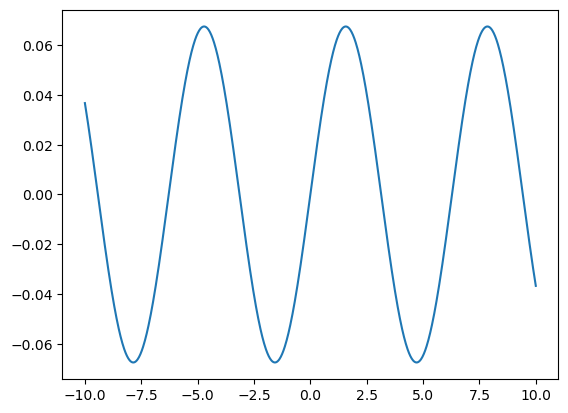

In [61]:
plt.plot(x_num, R1_ar)
print(2 * np.max(R1_ar))

0.1350199594261907


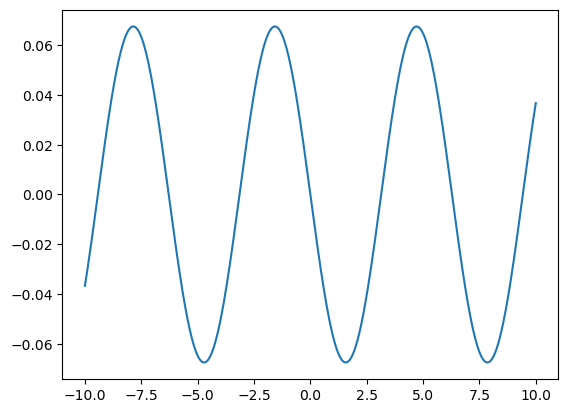

In [62]:
plt.plot(x_num, E1_ar)
print(2 * np.max(E1_ar))

0.06750997971309534


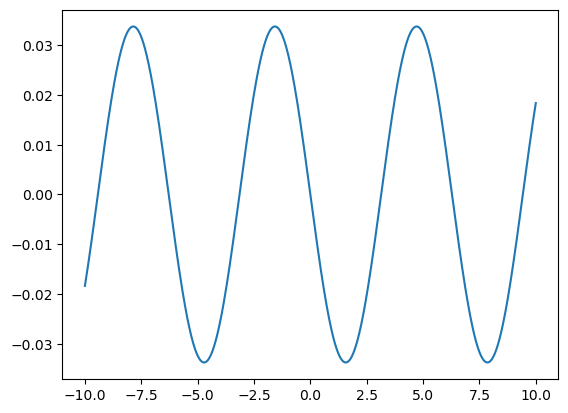

In [63]:
plt.plot(x_num, E2_ar)
print(2 * np.max(E2_ar))

0.060767983072414225


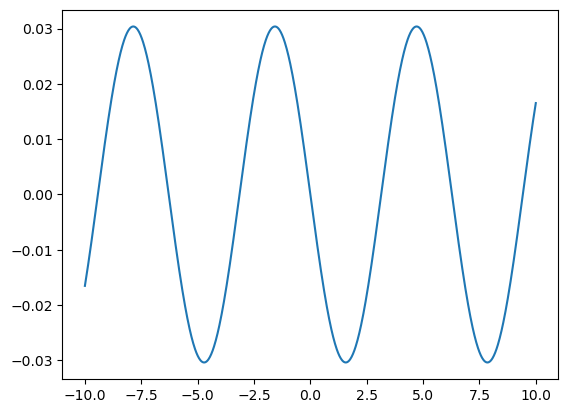

In [64]:
plt.plot(x_num, E31_ar)
print(2 * np.max(E31_ar))

-0.004557469234480989


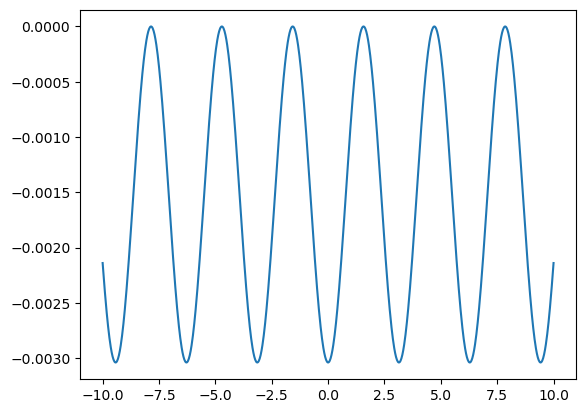

In [65]:
plt.plot(x_num, E32_ar1)
print(2 * np.min(E32_ar1) + np.max(E32_ar2))

## Print $L_3$ altogether to use autodiff

In [66]:
factor(E31[0], (phi_i.diff(x), phi_i.diff(y)))

⎛             ∂                       ∂                         ∂                       ∂           ⎞ ∂                 ⎛             ∂                       ∂            
⎜- 2⋅Q₁(x, y)⋅──(Q₁(x, y)) - Q₁(x, y)⋅──(Q₄(x, y)) - 2⋅Q₂(x, y)⋅──(Q₁(x, y)) - Q₂(x, y)⋅──(Q₄(x, y))⎟⋅──(\phiᵢ(x, y)) + ⎜- 2⋅Q₂(x, y)⋅──(Q₁(x, y)) - Q₂(x, y)⋅──(Q₄(x, y)) 
⎝             ∂x                      ∂x                        ∂y                      ∂y          ⎠ ∂x                ⎝             ∂x                      ∂x           

             ∂                       ∂           ⎞ ∂              
- 2⋅Q₄(x, y)⋅──(Q₁(x, y)) - Q₄(x, y)⋅──(Q₄(x, y))⎟⋅──(\phiᵢ(x, y))
             ∂y                      ∂y          ⎠ ∂y             

In [67]:
E32[0]

⎛                2                                             2                 2                 2                 2⎞            
⎜  ⎛∂           ⎞    ∂            ∂              ⎛∂           ⎞    ⎛∂           ⎞    ⎛∂           ⎞    ⎛∂           ⎞ ⎟            
⎜- ⎜──(Q₁(x, y))⎟  - ──(Q₁(x, y))⋅──(Q₄(x, y)) - ⎜──(Q₂(x, y))⎟  - ⎜──(Q₃(x, y))⎟  - ⎜──(Q₄(x, y))⎟  - ⎜──(Q₅(x, y))⎟ ⎟⋅\phiᵢ(x, y)
⎝  ⎝∂x          ⎠    ∂x           ∂x             ⎝∂x          ⎠    ⎝∂x          ⎠    ⎝∂x          ⎠    ⎝∂x          ⎠ ⎠            

In [68]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(simplify(- dt * L3 * (E31[i] + E32[i])), alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


In [69]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(simplify(- dt * L3 * (E31[i])), alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


In [70]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(simplify(- dt * L3 * (E32[i])), alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);


## Print $L_3$ analytic to test against auto-diff

In [71]:
assign_string = "    cell_matrix(i, j) +=\n"
# alen = len(assign_string)
alen = 12
space_str = ' ' * alen

term_list = [-simplify(dt * L3 * (dE31 + dE32))]
for i in range(vec_dim):
    for j in range(vec_dim):
        if (i == 0) and (j == 0):
            print("if (component_i == {} && component_j == {})".format(i, j))
        else:
            print("else if (component_i == {} && component_j == {})".format(i, j))

        print(assign_string, end="")
        print(space_str + "(\n", end="")
        
        nonzero_term_list = []
        for term in term_list:
            if not (term[i, j] == 0):
                nonzero_term_list.append(term)
        
        first_term = True
        for k, term in enumerate(nonzero_term_list):
            print_term(term[i, j], alen)
            first_term = False
            if not k == (len(nonzero_term_list) - 1):
                print(space_str, '+')

        print(space_str + ")")
        print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0 && component_j == 0)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 1)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 2)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 3)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 4)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 1 && component_j == 0)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 1 && component_j == 1)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 1 && component_j == 2)
    cell_matrix(i, j) +=
         

In [72]:
assign_string = "    cell_matrix(i, j) +=\n"
# alen = len(assign_string)
alen = 12
space_str = ' ' * alen

term_list = [-simplify(dt * L3 * (dE31))]
for i in range(vec_dim):
    for j in range(vec_dim):
        if (i == 0) and (j == 0):
            print("if (component_i == {} && component_j == {})".format(i, j))
        else:
            print("else if (component_i == {} && component_j == {})".format(i, j))

        print(assign_string, end="")
        print(space_str + "(\n", end="")
        
        nonzero_term_list = []
        for term in term_list:
            if not (term[i, j] == 0):
                nonzero_term_list.append(term)
        
        first_term = True
        for k, term in enumerate(nonzero_term_list):
            print_term(term[i, j], alen)
            first_term = False
            if not k == (len(nonzero_term_list) - 1):
                print(space_str, '+')

        print(space_str + ")")
        print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0 && component_j == 0)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 1)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 2)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 3)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 4)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 1 && component_j == 0)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 1 && component_j == 1)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 1 && component_j == 2)
    cell_matrix(i, j) +=
         

In [73]:
assign_string = "    cell_matrix(i, j) +=\n"
# alen = len(assign_string)
alen = 12
space_str = ' ' * alen

term_list = [-simplify(dt * L3 * (dE32))]
for i in range(vec_dim):
    for j in range(vec_dim):
        if (i == 0) and (j == 0):
            print("if (component_i == {} && component_j == {})".format(i, j))
        else:
            print("else if (component_i == {} && component_j == {})".format(i, j))

        print(assign_string, end="")
        print(space_str + "(\n", end="")
        
        nonzero_term_list = []
        for term in term_list:
            if not (term[i, j] == 0):
                nonzero_term_list.append(term)
        
        first_term = True
        for k, term in enumerate(nonzero_term_list):
            print_term(term[i, j], alen)
            first_term = False
            if not k == (len(nonzero_term_list) - 1):
                print(space_str, '+')

        print(space_str + ")")
        print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0 && component_j == 0)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 1)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 2)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 3)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 4)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 1 && component_j == 0)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 1 && component_j == 1)
    cell_matrix(i, j) +=
            (
            )
            * fe_values.JxW(q);
else if (component_i == 1 && component_j == 2)
    cell_matrix(i, j) +=
         

## Print out energy of configuration

In [76]:
fe1 = Rational(1, 2) * ( grad(Q).ip(grad(Q)) )
fe2 = L2 * Rational(1, 2) * ( div(Q) * div(Q) )
fe3 = L3 * Rational(1, 2) * (Q ** (grad(Q) ** transpose_3(grad(Q))))

fe = fe1 + fe2 + fe3
fe = simplify(fe)

E = - Rational(1, 2) * alpha * (Q ** Q)
E = simplify(E)

H = E + fe
H = simplify(H)

delta_S = -(log(4 * pi)
           - log(Z)
           + Lambda ** (Q + Rational(1, 3) * delta)
           )
delta_S = simplify(delta_S)

F = simplify(H - delta_S)
display(F)

   ⎛                             2                                2                                2⎞      ⎛                                                               
   ⎜⎛∂              ∂           ⎞    ⎛∂              ∂           ⎞    ⎛∂              ∂           ⎞ ⎟      ⎜  ⎛⎛∂              ∂           ⎞ ⎛∂              ∂           ⎞ 
L₂⋅⎜⎜──(Q₁(x, y)) + ──(Q₂(x, y))⎟  + ⎜──(Q₂(x, y)) + ──(Q₄(x, y))⎟  + ⎜──(Q₃(x, y)) + ──(Q₅(x, y))⎟ ⎟   L₃⋅⎜2⋅⎜⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟ 
   ⎝⎝∂x             ∂y          ⎠    ⎝∂x             ∂y          ⎠    ⎝∂x             ∂y          ⎠ ⎠      ⎝  ⎝⎝∂x             ∂x          ⎠ ⎝∂y             ∂y          ⎠ 
───────────────────────────────────────────────────────────────────────────────────────────────────── + ───────────────────────────────────────────────────────────────────
                                                  2                                                                                         

In [75]:
alen = 0
space_str = ""

print( print_term(E, alen) )
print(space_str, '+')
print( print_term(fe1, alen) )
print(space_str, '+')
print( print_term(fe2, alen) )
print(space_str, '+')
print( print_term(fe3, alen) )
print(space_str, '+')
print( print_term(-delta_S, alen) )

print(space_str, '* fe_values.JxW(q);', sep='')

 (alpha*(-(Q_vec[q][0]) * (Q_vec[q][0]) - Q_vec[q][0]*Q_vec[q][3] - (Q_vec[q][1]) * (Q_vec[q][1]) - (Q_vec[q][2]) * (Q_vec[q][2]) - (Q_vec[q][3]) * (Q_vec[q][3]) - (Q_vec[q][4]) * (Q_vec[q][4])))
 +
 ((1.0/2.0)*(-dQ[q][0][0] - dQ[q][3][0]) * (-dQ[q][0][0] - dQ[q][3][0]) + (1.0/2.0)*(-dQ[q][0][1] - dQ[q][3][1]) * (-dQ[q][0][1] - dQ[q][3][1]) + (1.0/2.0)*(dQ[q][0][0]) * (dQ[q][0][0]) + (1.0/2.0)*(dQ[q][0][1]) * (dQ[q][0][1]) + (dQ[q][1][0]) * (dQ[q][1][0]) + (dQ[q][1][1]) * (dQ[q][1][1]) + (dQ[q][2][0]) * (dQ[q][2][0]) + (dQ[q][2][1]) * (dQ[q][2][1]) + (1.0/2.0)*(dQ[q][3][0]) * (dQ[q][3][0]) + (1.0/2.0)*(dQ[q][3][1]) * (dQ[q][3][1]) + (dQ[q][4][0]) * (dQ[q][4][0]) + (dQ[q][4][1]) * (dQ[q][4][1]))
 +
 ((1.0/2.0)*L2*((dQ[q][0][0] + dQ[q][1][1]) * (dQ[q][0][0] + dQ[q][1][1]) + (dQ[q][1][0] + dQ[q][3][1]) * (dQ[q][1][0] + dQ[q][3][1]) + (dQ[q][2][0] + dQ[q][4][1]) * (dQ[q][2][0] + dQ[q][4][1])))
 +
 ((1.0/2.0)*L3*(2*((-dQ[q][0][0] - dQ[q][3][0])*(-dQ[q][0][1] - dQ[q][3][1]) + dQ[q][0][0]*dQ[

## Print out energy variation

In [77]:
I = MyMArray([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [78]:
bulk_term = MyMArray( simplify( alpha * Q ) )
entropy_term = MyMArray( simplify( -Lambda ) )
L1_term = MyMArray( simplify( div(grad(Q)) ) )
L2_term = MyMArray( simplify( L2 / 2 * ( grad(div(Q)) 
                                         + grad(div(Q)).transpose() 
                                         - Rational(2, 3) * div(div(Q)) * I ) ) )
L3_term = MyMArray( simplify( L3 / 2 * ( 2 * div(Q * grad(Q)) 
                                        - (grad(Q)) ** transpose_3(grad(Q)) 
                                        + Rational(1, 3) * grad(Q).ip(grad(Q)) * I) ) )

display(bulk_term)
display(entropy_term)
display(L1_term)
display(L2_term)
display(L3_term)

⎡\alpha⋅Q₁(x, y)  \alpha⋅Q₂(x, y)         \alpha⋅Q₃(x, y)       ⎤
⎢                                                               ⎥
⎢\alpha⋅Q₂(x, y)  \alpha⋅Q₄(x, y)         \alpha⋅Q₅(x, y)       ⎥
⎢                                                               ⎥
⎣\alpha⋅Q₃(x, y)  \alpha⋅Q₅(x, y)  -\alpha⋅(Q₁(x, y) + Q₄(x, y))⎦

⎡-\Lambda₁(x, y)  -\Lambda₂(x, y)          -\Lambda₃(x, y)        ⎤
⎢                                                                 ⎥
⎢-\Lambda₂(x, y)  -\Lambda₄(x, y)          -\Lambda₅(x, y)        ⎥
⎢                                                                 ⎥
⎣-\Lambda₃(x, y)  -\Lambda₅(x, y)  \Lambda₁(x, y) + \Lambda₄(x, y)⎦

⎡  2               2              2               2                               2               2                           ⎤
⎢ ∂               ∂              ∂               ∂                               ∂               ∂                            ⎥
⎢───(Q₁(x, y)) + ───(Q₁(x, y))  ───(Q₂(x, y)) + ───(Q₂(x, y))                   ───(Q₃(x, y)) + ───(Q₃(x, y))                 ⎥
⎢  2               2              2               2                               2               2                           ⎥
⎢∂x              ∂y             ∂x              ∂y                              ∂x              ∂y                            ⎥
⎢                                                                                                                             ⎥
⎢  2               2              2               2                               2               2                           ⎥
⎢ ∂               ∂              ∂               ∂                               ∂               ∂      

⎡           ⎛    2               2                2           ⎞             ⎛  2               2                2                 2           ⎞               ⎛  2         
⎢           ⎜   ∂               ∂                ∂            ⎟             ⎜ ∂               ∂                ∂                 ∂            ⎟               ⎜ ∂          
⎢        L₂⋅⎜2⋅───(Q₁(x, y)) - ───(Q₄(x, y)) + ─────(Q₂(x, y))⎟          L₂⋅⎜───(Q₂(x, y)) + ───(Q₂(x, y)) + ─────(Q₁(x, y)) + ─────(Q₄(x, y))⎟            L₂⋅⎜───(Q₃(x, y)
⎢           ⎜    2               2             ∂y ∂x          ⎟             ⎜  2               2             ∂y ∂x             ∂y ∂x          ⎟               ⎜  2         
⎢           ⎝  ∂x              ∂y                             ⎠             ⎝∂x              ∂y                                               ⎠               ⎝∂x          
⎢        ──────────────────────────────────────────────────────          ───────────────────────────────────────────────────────────────────

⎡   ⎛             2                           2                           2                           2                                                                    
⎢   ⎜            ∂                           ∂                           ∂              ⎛∂           ⎞      ∂            ∂                ∂            ∂              ⎛∂   
⎢L₃⋅⎜3⋅Q₁(x, y)⋅───(Q₁(x, y)) + 6⋅Q₂(x, y)⋅─────(Q₁(x, y)) + 3⋅Q₄(x, y)⋅───(Q₁(x, y)) + ⎜──(Q₁(x, y))⎟  + 3⋅──(Q₁(x, y))⋅──(Q₂(x, y)) - 2⋅──(Q₁(x, y))⋅──(Q₄(x, y)) + ⎜──(Q
⎢   ⎜             2                        ∂y ∂x                          2             ⎝∂x          ⎠      ∂x           ∂y               ∂x           ∂x             ⎝∂y  
⎢   ⎝           ∂x                                                      ∂y                                                                                                 
⎢───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [87]:
bulk_term_vec = zeros(vec_dim, 1)
entropy_term_vec = zeros(vec_dim, 1)
L1_term_vec = zeros(vec_dim, 1)
L2_term_vec = zeros(vec_dim, 1)
L3_term_vec = zeros(vec_dim, 1)

bulk_term_vec[0] = bulk_term[0, 0]
bulk_term_vec[1] = bulk_term[0, 1]
bulk_term_vec[2] = bulk_term[0, 2]
bulk_term_vec[3] = bulk_term[1, 1]
bulk_term_vec[4] = bulk_term[1, 2]

entropy_term_vec[0] = entropy_term[0, 0]
entropy_term_vec[1] = entropy_term[0, 1]
entropy_term_vec[2] = entropy_term[0, 2]
entropy_term_vec[3] = entropy_term[1, 1]
entropy_term_vec[4] = entropy_term[1, 2]

L1_term_vec[0] = L1_term[0, 0]
L1_term_vec[1] = L1_term[0, 1]
L1_term_vec[2] = L1_term[0, 2]
L1_term_vec[3] = L1_term[1, 1]
L1_term_vec[4] = L1_term[1, 2]

L2_term_vec[0] = L2_term[0, 0]
L2_term_vec[1] = L2_term[0, 1]
L2_term_vec[2] = L2_term[0, 2]
L2_term_vec[3] = L2_term[1, 1]
L2_term_vec[4] = L2_term[1, 2]

L3_term_vec[0] = L3_term[0, 0]
L3_term_vec[1] = L3_term[0, 1]
L3_term_vec[2] = L3_term[0, 2]
L3_term_vec[3] = L3_term[1, 1]
L3_term_vec[4] = L3_term[1, 2]

In [104]:
alen = 4
blen = 3
space_str = ' '*alen
energy_components = 5

for i in range(vec_dim):
    print('computed_quantities[q]({}) ='.format(i))
    print( print_term(bulk_term_vec[i], blen), end=';\n' )
    
print()
for i in range(vec_dim):
    print('computed_quantities[q]({}) ='.format(i + 1*energy_components))
    print( print_term(entropy_term_vec[i], blen), end=';\n' )
    
print()
for i in range(vec_dim):
    print('computed_quantities[q]({}) ='.format(i + 2*energy_components))
    print( print_term(L1_term_vec[i], blen), end=';\n' )
    
print()
for i in range(vec_dim):
    print('computed_quantities[q]({}) ='.format(i + 3*energy_components))
    print( print_term(L2_term_vec[i], blen), end=';\n' )
    
print()
for i in range(vec_dim):
    print('computed_quantities[q]({}) ='.format(i + 4*energy_components))
    print( print_term(L3_term_vec[i], blen), end=';\n' )

computed_quantities[q](0) =
    (alpha*Q_vec[q][0]);
computed_quantities[q](1) =
    (alpha*Q_vec[q][1]);
computed_quantities[q](2) =
    (alpha*Q_vec[q][2]);
computed_quantities[q](3) =
    (alpha*Q_vec[q][3]);
computed_quantities[q](4) =
    (alpha*Q_vec[q][4]);

computed_quantities[q](5) =
    (-Lambda_vec[0]);
computed_quantities[q](6) =
    (-Lambda_vec[1]);
computed_quantities[q](7) =
    (-Lambda_vec[2]);
computed_quantities[q](8) =
    (-Lambda_vec[3]);
computed_quantities[q](9) =
    (-Lambda_vec[4]);

computed_quantities[q](10) =
    (ddQ[q][0][0][0] + ddQ[q][0][1][1]);
computed_quantities[q](11) =
    (ddQ[q][1][0][0] + ddQ[q][1][1][1]);
computed_quantities[q](12) =
    (ddQ[q][2][0][0] + ddQ[q][2][1][1]);
computed_quantities[q](13) =
    (ddQ[q][3][0][0] + ddQ[q][3][1][1]);
computed_quantities[q](14) =
    (ddQ[q][4][0][0] + ddQ[q][4][1][1]);

computed_quantities[q](15) =
    ((1.0/3.0)*L2*(2*ddQ[q][0][0][0] - ddQ[q][3][1][1] + ddQ[q][1][0][1]));
computed_quantities[q](16) 

In [79]:
dE_dQ = bulk_term + entropy_term + L1_term + L2_term + L3_term
dE_dQ_squared = simplify(dE_dQ ** dE_dQ)

In [80]:
dE_dQ_squared

                                                                                                                                                                           
⎛   ⎛  2                2           ⎞        ⎛           2                           2                         2                                                           
⎜   ⎜ ∂                ∂            ⎟        ⎜          ∂                           ∂                         ∂              ∂            ∂              ∂            ∂    
⎜L₂⋅⎜───(Q₃(x, y)) + ─────(Q₅(x, y))⎟ + 2⋅L₃⋅⎜Q₁(x, y)⋅───(Q₃(x, y)) + 2⋅Q₂(x, y)⋅─────(Q₃(x, y)) + Q₄(x, y)⋅───(Q₃(x, y)) + ──(Q₁(x, y))⋅──(Q₃(x, y)) + ──(Q₂(x, y))⋅──(Q₃
⎜   ⎜  2             ∂y ∂x          ⎟        ⎜           2                        ∂y ∂x                        2             ∂x           ∂x             ∂x           ∂y   
⎝   ⎝∂x                             ⎠        ⎝         ∂x                                                    ∂y                             

In [81]:
my_printer = MyPrinter()
term_str = my_printer.doprint(dE_dQ_squared)

print(term_str)

(1.0/2.0)*(L2*(ddQ[q][2][0][0] + ddQ[q][4][0][1]) + 2*L3*(Q_vec[q][0]*ddQ[q][2][0][0] + 2*Q_vec[q][1]*ddQ[q][2][0][1] + Q_vec[q][3]*ddQ[q][2][1][1] + dQ[q][0][0]*dQ[q][2][0] + dQ[q][1][0]*dQ[q][2][1] + dQ[q][1][1]*dQ[q][2][0] + dQ[q][2][1]*dQ[q][3][1]) + 2*alpha*Q_vec[q][2] - 2*Lambda_vec[2] + 2*ddQ[q][2][0][0] + 2*ddQ[q][2][1][1]) * (L2*(ddQ[q][2][0][0] + ddQ[q][4][0][1]) + 2*L3*(Q_vec[q][0]*ddQ[q][2][0][0] + 2*Q_vec[q][1]*ddQ[q][2][0][1] + Q_vec[q][3]*ddQ[q][2][1][1] + dQ[q][0][0]*dQ[q][2][0] + dQ[q][1][0]*dQ[q][2][1] + dQ[q][1][1]*dQ[q][2][0] + dQ[q][2][1]*dQ[q][3][1]) + 2*alpha*Q_vec[q][2] - 2*Lambda_vec[2] + 2*ddQ[q][2][0][0] + 2*ddQ[q][2][1][1]) + (1.0/2.0)*(L2*(ddQ[q][4][1][1] + ddQ[q][2][0][1]) + 2*L3*(Q_vec[q][0]*ddQ[q][4][0][0] + 2*Q_vec[q][1]*ddQ[q][4][0][1] + Q_vec[q][3]*ddQ[q][4][1][1] + dQ[q][0][0]*dQ[q][4][0] + dQ[q][1][0]*dQ[q][4][1] + dQ[q][1][1]*dQ[q][4][0] + dQ[q][3][1]*dQ[q][4][1]) + 2*alpha*Q_vec[q][4] - 2*Lambda_vec[4] + 2*ddQ[q][4][0][0] + 2*ddQ[q][4][1][1]) * (L

In [82]:
print(term_str.replace('+', '\n+').replace('-', '\n-'))

(1.0/2.0)*(L2*(ddQ[q][2][0][0] 
+ ddQ[q][4][0][1]) 
+ 2*L3*(Q_vec[q][0]*ddQ[q][2][0][0] 
+ 2*Q_vec[q][1]*ddQ[q][2][0][1] 
+ Q_vec[q][3]*ddQ[q][2][1][1] 
+ dQ[q][0][0]*dQ[q][2][0] 
+ dQ[q][1][0]*dQ[q][2][1] 
+ dQ[q][1][1]*dQ[q][2][0] 
+ dQ[q][2][1]*dQ[q][3][1]) 
+ 2*alpha*Q_vec[q][2] 
- 2*Lambda_vec[2] 
+ 2*ddQ[q][2][0][0] 
+ 2*ddQ[q][2][1][1]) * (L2*(ddQ[q][2][0][0] 
+ ddQ[q][4][0][1]) 
+ 2*L3*(Q_vec[q][0]*ddQ[q][2][0][0] 
+ 2*Q_vec[q][1]*ddQ[q][2][0][1] 
+ Q_vec[q][3]*ddQ[q][2][1][1] 
+ dQ[q][0][0]*dQ[q][2][0] 
+ dQ[q][1][0]*dQ[q][2][1] 
+ dQ[q][1][1]*dQ[q][2][0] 
+ dQ[q][2][1]*dQ[q][3][1]) 
+ 2*alpha*Q_vec[q][2] 
- 2*Lambda_vec[2] 
+ 2*ddQ[q][2][0][0] 
+ 2*ddQ[q][2][1][1]) 
+ (1.0/2.0)*(L2*(ddQ[q][4][1][1] 
+ ddQ[q][2][0][1]) 
+ 2*L3*(Q_vec[q][0]*ddQ[q][4][0][0] 
+ 2*Q_vec[q][1]*ddQ[q][4][0][1] 
+ Q_vec[q][3]*ddQ[q][4][1][1] 
+ dQ[q][0][0]*dQ[q][4][0] 
+ dQ[q][1][0]*dQ[q][4][1] 
+ dQ[q][1][1]*dQ[q][4][0] 
+ dQ[q][3][1]*dQ[q][4][1]) 
+ 2*alpha*Q_vec[q][4] 
- 2*Lambda_vec[4] 
+ 2*ddQ[q

## Write Landau-de Gennes weak form